# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka

from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets

In [3]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

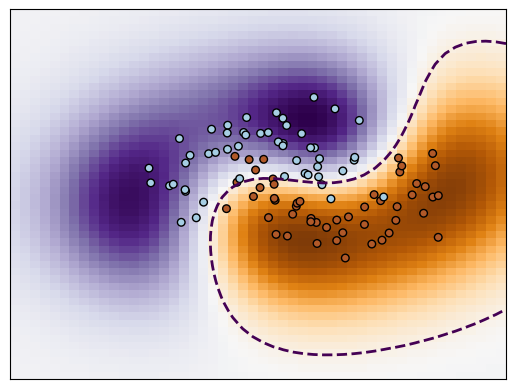

In [4]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

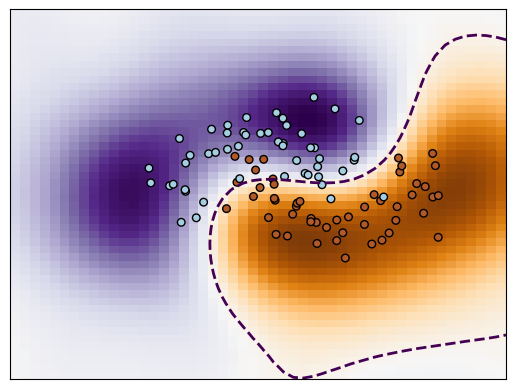

In [5]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

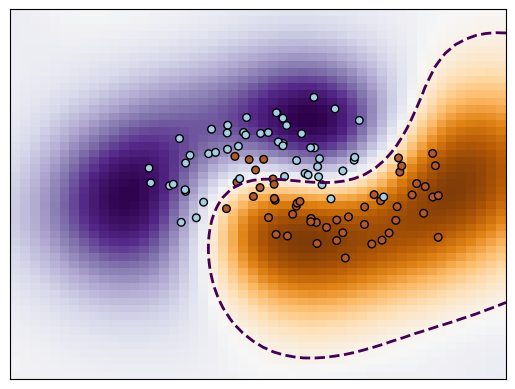

In [6]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
random_features = rbf_sampler.fit_transform(n_random_features, X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

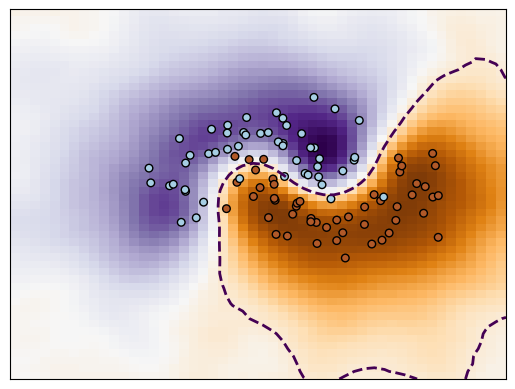

In [7]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)    
random_features = matern_sampler.fit_transform(n_random_features, X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

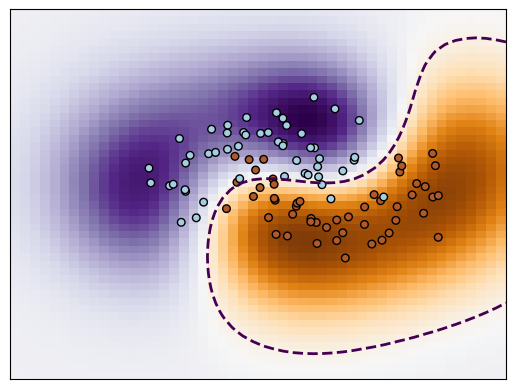

In [8]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py



In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import svm

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# A not so simple 2D problem
noise = 0.3

# Training set 
X_train, y_train = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Scale the data to range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "Best Parameters", "Train Accuracy", "Test Accuracy"])

def evaluate_model(model_name, pipeline, param_grid):
    global results_df
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Training accuracy
    y_train_pred = best_model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Test accuracy
    y_test_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store results
    results_df = pd.concat([results_df, pd.DataFrame([{ 
        "Model": model_name, 
        "Best Parameters": best_params, 
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    }])], ignore_index=True)
    
    print(f"{model_name} - Best Parameters: {best_params}")
    print(f"{model_name} - Train Accuracy: {train_accuracy}")
    print(f"{model_name} - Test Accuracy: {test_accuracy}")

    return best_model


In [12]:
# First model: SVC with RBF kernel
param_grid_svc = {
    'clf__gamma': [0.01, 0.1, 1, 10, 100]
}

pipeline_svc = Pipeline([
    ('clf', svm.SVC(kernel='rbf'))
])

svm_best_model = evaluate_model("SVM RBF", pipeline_svc, param_grid_svc)

SVM RBF - Best Parameters: {'clf__gamma': 10}
SVM RBF - Train Accuracy: 0.95
SVM RBF - Test Accuracy: 0.91


C:\Users\nerea\AppData\Local\Temp\ipykernel_14764\3645306288.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


In [13]:
# Define the hyperparameter grid for RBF Fourier random features model
param_grid_rbf_fourier = {
    'rbf__gamma': [0.01, 0.1, 1, 10],
    'rbf__n_components': [500, 1000, 5000, 10000, 50000],  # Number of random features
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter for SVC
}

# Create a pipeline for RBF Fourier random features
pipeline_rbf_fourier = Pipeline([
    ('rbf', RBFSampler(random_state=1)),
    ('clf', svm.SVC(kernel='linear'))
])

# Evaluate the RBF Fourier model
RBF_best_model = evaluate_model("RBF Fourier Features SVM", pipeline_rbf_fourier, param_grid_rbf_fourier)

RBF Fourier Features SVM - Best Parameters: {'clf__C': 100, 'rbf__gamma': 1, 'rbf__n_components': 500}
RBF Fourier Features SVM - Train Accuracy: 0.96
RBF Fourier Features SVM - Test Accuracy: 0.907


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

# Define the hyperparameter grid for our RBF Fourier random features implementation
param_grid_rbf_custom = {
    'rbf__sigma': [0.01, 0.1, 1, 10],  
    'rbf__n_random_features': [500, 1000, 5000, 10000, 50000],  
    'clf__C': [0.01, 0.1, 1, 10, 100]  
}

# Custom transformer wrapper for our implementation of RBF Fourier features
class CustomRBFSampler(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=1.0, n_random_features=1000):
        self.sigma = sigma
        self.n_random_features = n_random_features
        self.rbf_sampler = None

    def fit(self, X, y=None):
        self.rbf_sampler = ka.RandomFeaturesSamplerRBF(self.sigma)
        self.rbf_sampler.fit_transform(self.n_random_features, X)
        return self

    def transform(self, X):
        return self.rbf_sampler.transform(X)

# Create a pipeline for our RBF Fourier random features implementation
pipeline_rbf_custom = Pipeline([
    ('rbf', CustomRBFSampler()),  # Our custom transformer
    ('clf', svm.SVC(kernel='linear'))
])

# Evaluate the custom RBF Fourier features model
customRBF_best_model = evaluate_model("Custom RBF Fourier Features SVM", pipeline_rbf_custom, param_grid_rbf_custom)

Custom RBF Fourier Features SVM - Best Parameters: {'clf__C': 1, 'rbf__n_random_features': 1000, 'rbf__sigma': 0.1}
Custom RBF Fourier Features SVM - Train Accuracy: 0.98
Custom RBF Fourier Features SVM - Test Accuracy: 0.878


In [15]:
# Define the hyperparameter grid for Matérn Fourier random features implementation
param_grid_matern_custom = {
    'matern__length_scale': [0.01, 0.1, 1, 10],  # Length scale (sigma)
    'matern__nu': [0.5, 1.5, 2.5],  # Different values of nu
    'matern__n_random_features': [500, 1000, 5000, 10000, 50000],  # Number of random features
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter for SVC
}

# Custom transformer wrapper for our implementation of Matérn Fourier features
class CustomMaternSampler(BaseEstimator, TransformerMixin):
    def __init__(self, length_scale=1.0, nu=1.5, n_random_features=1000):
        self.length_scale = length_scale
        self.nu = nu
        self.n_random_features = n_random_features
        self.matern_sampler = None

    def fit(self, X, y=None):
        self.matern_sampler = ka.RandomFeaturesSamplerMatern(self.length_scale, self.nu)
        self.matern_sampler.fit_transform(self.n_random_features, X)
        return self

    def transform(self, X):
        return self.matern_sampler.transform(X)

# Create a pipeline for Matérn Fourier random features
pipeline_matern_custom = Pipeline([
    ('matern', CustomMaternSampler()),  # Custom Matérn transformer
    ('clf', svm.SVC(kernel='linear'))
])

# Evaluate the custom Matérn Fourier features model
customMatern_best_model = evaluate_model("Custom Matérn Fourier Features SVM", pipeline_matern_custom, param_grid_matern_custom)


Custom Matérn Fourier Features SVM - Best Parameters: {'clf__C': 100, 'matern__length_scale': 1, 'matern__n_random_features': 500, 'matern__nu': 1.5}
Custom Matérn Fourier Features SVM - Train Accuracy: 0.97
Custom Matérn Fourier Features SVM - Test Accuracy: 0.899


In [16]:
# Define the hyperparameter grid for Nystroem features implementation
param_grid_nystroem_custom = {
    'nystroem__gamma': [0.01, 0.1, 1, 10, 100],  # Gamma for RBF kernel
    'nystroem__n_nystroem_features': [10, 20, 50, 75],  # Number of Nystroem features
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter for SVC
}

# Custom transformer wrapper for our implementation of Nystroem features
class CustomNystroemSampler(BaseEstimator, TransformerMixin):
    def __init__(self, gamma=1.0, n_nystroem_features=20):
        self.gamma = gamma
        self.n_nystroem_features = n_nystroem_features
        self.nystroem_sampler = None

    def fit(self, X, y=None):
        def kernel_fn(A, B):  # Define the RBF kernel function
            return rbf_kernel(A, B, gamma=self.gamma)

        self.nystroem_sampler = ka.NystroemFeaturesSampler(kernel_fn)
        self.nystroem_sampler.fit_transform(self.n_nystroem_features, X)
        return self

    def transform(self, X):
        return self.nystroem_sampler.transform(X)

# Create a pipeline for Nystroem features
pipeline_nystroem_custom = Pipeline([
    ('nystroem', CustomNystroemSampler()),  # Custom Nystroem transformer
    ('clf', svm.SVC(kernel='linear'))
])

# Evaluate the custom Nystroem features model
customNystroem_best_model = evaluate_model("Custom Nystroem Features SVM", pipeline_nystroem_custom, param_grid_nystroem_custom)


Custom Nystroem Features SVM - Best Parameters: {'clf__C': 1, 'nystroem__gamma': 10, 'nystroem__n_nystroem_features': 75}
Custom Nystroem Features SVM - Train Accuracy: 0.95
Custom Nystroem Features SVM - Test Accuracy: 0.911


In [17]:
results_df

,Model,Best Parameters,Train Accuracy,Test Accuracy
0,SVM RBF,{'clf__gamma': 10},0.95,0.910
1,RBF Fourier Features SVM,"{'clf__C': 100, 'rbf__gamma': 1, 'rbf__n_compo...",0.96,0.907
2,Custom RBF Fourier Features SVM,"{'clf__C': 1, 'rbf__n_random_features': 1000, ...",0.98,0.878
3,Custom Matérn Fourier Features SVM,"{'clf__C': 100, 'matern__length_scale': 1, 'ma...",0.97,0.899
4,Custom Nystroem Features SVM,"{'clf__C': 1, 'nystroem__gamma': 10, 'nystroem...",0.95,0.911


El mejor modelo en términos de accuracy en el conjunto de prueba es el Custom Nystroem Features SVM, con una precisión de 0.911, seguido muy de cerca por el SVM RBF, que alcanza un 0.910. El RBF Fourier Features SVM también muestra un buen desempeño con un 0.907, mientras que el Custom Matérn Fourier Features SVM obtiene un 0.899. Por otro lado, el Custom RBF Fourier Features SVM es el modelo con la menor precisión en el conjunto de prueba, con un 0.878, a pesar de haber alcanzado la mayor precisión en entrenamiento (0.98), lo que sugiere un posible sobreajuste al conjunto de entrenamiento.
